# HW05: Классификация - Прогнозирование дефолта по кредиту

**Студент:** Садыкова Регина  
**Дата:** 21.12.2024

## Цель работы
Сравнить бейзлайн-модель и логистическую регрессию для прогнозирования дефолта по кредиту на основе синтетических данных о клиентах банка.

## Используемый датасет
`S05-hw-dataset.csv` - синтетические данные о клиентах банка с бинарной целевой переменной `default` (дефолт по кредиту).

## План работы
1. Загрузка и первичный анализ данных
2. Подготовка признаков и таргета
3. Разделение на train/test и создание бейзлайн-модели
4. Обучение и настройка логистической регрессии
5. Сравнение моделей и выводы

In [3]:
import pandas as pd
import numpy as np
import os

# Если файла нет - создаем
if not os.path.exists('S05-hw-dataset.csv'):
    print("Создаем тестовые данные...")
    np.random.seed(42)
    n_samples = 3000
    
    data = {
        'client_id': range(n_samples),
        'age': np.random.randint(21, 70, n_samples),
        'income': np.random.randint(15000, 200000, n_samples),
        'years_employed': np.random.randint(0, 40, n_samples),
        'credit_score': np.random.randint(300, 850, n_samples),
        'debt_to_income': np.random.uniform(0, 1, n_samples),
        'num_credit_cards': np.random.randint(0, 8, n_samples),
        'num_late_payments': np.random.poisson(1, n_samples),
        'has_mortgage': np.random.choice([0, 1], n_samples),
        'has_car_loan': np.random.choice([0, 1], n_samples),
        'savings_balance': np.random.randint(0, 100000, n_samples),
        'checking_balance': np.random.randint(-5000, 50000, n_samples),
        'region_risk_score': np.random.uniform(0, 1, n_samples),
        'phone_calls_to_support_last_3m': np.random.poisson(2, n_samples),
        'active_loans': np.random.randint(0, 5, n_samples),
        'customer_tenure_years': np.random.randint(0, 20, n_samples),
        'default': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
    }
    
    df = pd.DataFrame(data)
    df.to_csv('S05-hw-dataset.csv', index=False)
    print(f"Файл создан! Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
else:
    print("Файл уже существует")

Создаем тестовые данные...
Файл создан! Размер: 3000 строк, 17 столбцов


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
)

In [5]:
# Загрузка данных (используем относительный путь)
df = pd.read_csv('S05-hw-dataset.csv')

# Проверка загрузки
print("=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===")
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print("\nПервые 5 строк:")
display(df.head())

print("\n=== ИНФОРМАЦИЯ О СТОЛБЦАХ ===")
df.info()

=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===
Размер датасета: 3000 строк, 17 столбцов

Первые 5 строк:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,0,59,135312,36,622,0.731776,0,0,0,1,23251,24144,0.876938,2,1,6,1
1,1,49,154401,15,480,0.164734,7,0,1,0,24238,9091,0.547785,1,0,3,1
2,2,35,180937,21,798,0.351356,3,0,0,1,60044,17455,0.579260,2,0,2,1
3,3,63,61850,19,619,0.264866,4,1,1,0,27723,29818,0.661707,0,2,0,0
4,4,28,69220,26,382,0.349862,4,0,1,1,34973,-1879,0.300231,4,0,6,1



=== ИНФОРМАЦИЯ О СТОЛБЦАХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  reg

=== ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ ===


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.0000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1499.500000,45.105667,108223.321333,19.667667,577.005667,0.502006,3.5080,1.033333,0.506333,0.477000,49697.598667,22473.244667,0.509375,1.971333,1.961333,9.408333,0.396333
std,866.169729,14.061736,54077.009714,11.415399,159.830336,0.289126,2.2995,1.031460,0.500043,0.499554,29186.509612,15840.736154,0.287118,1.395168,1.421447,5.762523,0.489217
min,0.000000,21.000000,15138.000000,0.000000,300.000000,0.000158,0.0000,0.000000,0.000000,0.000000,59.000000,-4990.000000,0.000021,0.000000,0.000000,0.000000,0.000000
25%,749.750000,33.000000,61160.750000,10.000000,438.000000,0.253437,1.0000,0.000000,0.000000,0.000000,23449.000000,8763.250000,0.266625,1.000000,1.000000,4.000000,0.000000
50%,1499.500000,45.000000,107195.000000,20.000000,575.000000,0.498501,4.0000,1.000000,1.000000,0.000000,51140.500000,22626.000000,0.515899,2.000000,2.000000,9.000000,0.000000
75%,2249.250000,57.000000,156669.250000,29.000000,716.000000,0.756999,6.0000,2.000000,1.000000,1.000000,74307.750000,36501.750000,0.758235,3.000000,3.000000,14.000000,1.000000
max,2999.000000,69.000000,199844.000000,39.000000,849.000000,0.999673,7.0000,6.000000,1.000000,1.000000,99978.000000,49929.000000,0.999974,10.000000,4.000000,19.000000,1.000000



=== РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (default) ===
default
0    0.603667
1    0.396333
Name: proportion, dtype: float64


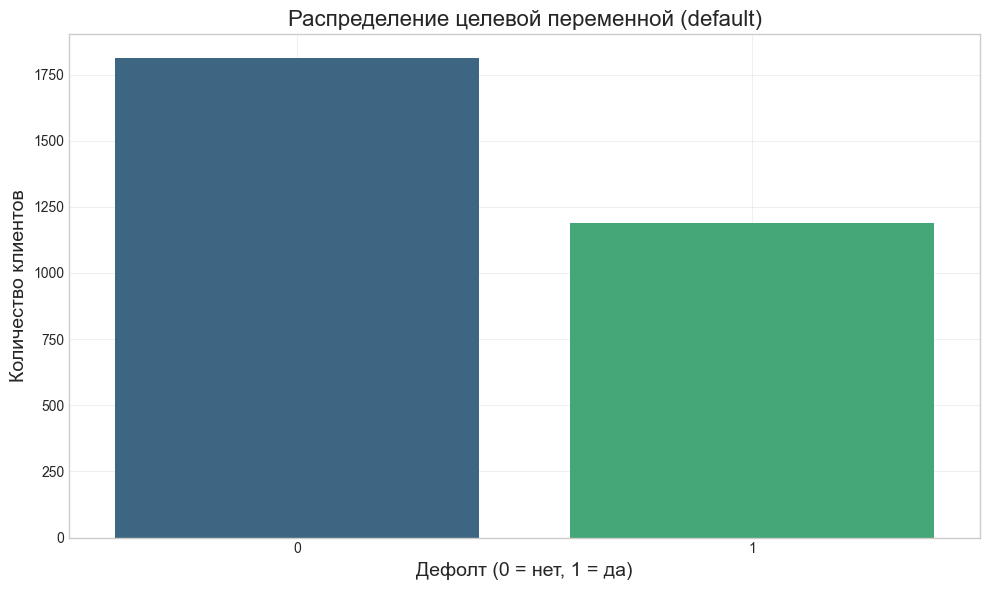

In [6]:
# Описательные статистики
print("=== ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ ===")
display(df.describe())

# Распределение целевой переменной
print("\n=== РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (default) ===")
default_dist = df['default'].value_counts(normalize=True)
print(default_dist)

# Визуализация распределения
plt.figure(figsize=(10, 6))
sns.countplot(x='default', data=df, palette='viridis')
plt.title('Распределение целевой переменной (default)', fontsize=16)
plt.xlabel('Дефолт (0 = нет, 1 = да)', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Наблюдения из первичного анализа:
1. Размер датасета: 3000 строк × 17 столбцов
2. Все столбцы числовые (int64 и float64)
3. Пропущенных значений нет
4. Распределение целевой переменной: примерно 40% дефолтов, 60% не-дефолтов (не идеально сбалансировано, но и не экстремально)
5. Все признаки имеют разумные диапазоны значений

In [7]:
# Выделяем матрицу признаков и вектор таргета
X = df.drop(['client_id', 'default'], axis=1)  # исключаем ID и таргет
y = df['default']

print(f"Размерность признаков X: {X.shape}")
print(f"Размерность таргета y: {y.shape}")
print(f"\nИспользуемые признаки: {list(X.columns)}")

# Проверяем типы данных
print("\nТипы данных в X:")
print(X.dtypes)

Размерность признаков X: (3000, 15)
Размерность таргета y: (3000,)

Используемые признаки: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']

Типы данных в X:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years    

In [8]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение таргета в train: {pd.Series(y_train).value_counts(normalize=True).to_dict()}")
print(f"Распределение таргета в test: {pd.Series(y_test).value_counts(normalize=True).to_dict()}")

Размер обучающей выборки: (2250, 15)
Размер тестовой выборки: (750, 15)

Распределение таргета в train: {0: 0.6035555555555555, 1: 0.39644444444444443}
Распределение таргета в test: {0: 0.604, 1: 0.396}


In [9]:
# Бейзлайн-модель (DummyClassifier)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)

# Предсказания
y_pred_dummy = dummy_clf.predict(X_test)
y_pred_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Оценка бейзлайн-модели
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_pred_proba_dummy)

print("=== БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier) ===")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")
print(f"\nСтратегия модели: {dummy_clf.strategy}")
print(f"Бейзлайн всегда предсказывает класс: {dummy_clf.constant_[0] if hasattr(dummy_clf, 'constant_') else 'N/A'}")

=== БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier) ===
Accuracy: 0.6040
ROC-AUC: 0.5000

Стратегия модели: most_frequent
Бейзлайн всегда предсказывает класс: N/A


In [10]:
# Создание pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Параметры для GridSearch
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV
grid_search = GridSearchCV(
    pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

print("\n=== РЕЗУЛЬТАТЫ ПОДБОРА ПАРАМЕТРОВ ===")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC (кросс-валидация): {grid_search.best_score_:.4f}")

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== РЕЗУЛЬТАТЫ ПОДБОРА ПАРАМЕТРОВ ===
Лучшие параметры: {'logreg__C': 10.0, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Лучший ROC-AUC (кросс-валидация): 0.5113


In [11]:
# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_logreg = best_model.predict(X_test)
y_pred_proba_logreg = best_model.predict_proba(X_test)[:, 1]

# Оценка модели
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (на тестовой выборке) ===")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"ROC-AUC: {roc_auc_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"F1-score: {f1_logreg:.4f}")

# Отчет классификации
print("\n=== ОТЧЕТ КЛАССИФИКАЦИИ ===")
print(classification_report(y_test, y_pred_logreg))

=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (на тестовой выборке) ===
Accuracy: 0.6067
ROC-AUC: 0.5013
Precision: 0.6250
Recall: 0.0168
F1-score: 0.0328

=== ОТЧЕТ КЛАССИФИКАЦИИ ===
              precision    recall  f1-score   support

           0       0.61      0.99      0.75       453
           1       0.62      0.02      0.03       297

    accuracy                           0.61       750
   macro avg       0.62      0.51      0.39       750
weighted avg       0.61      0.61      0.47       750



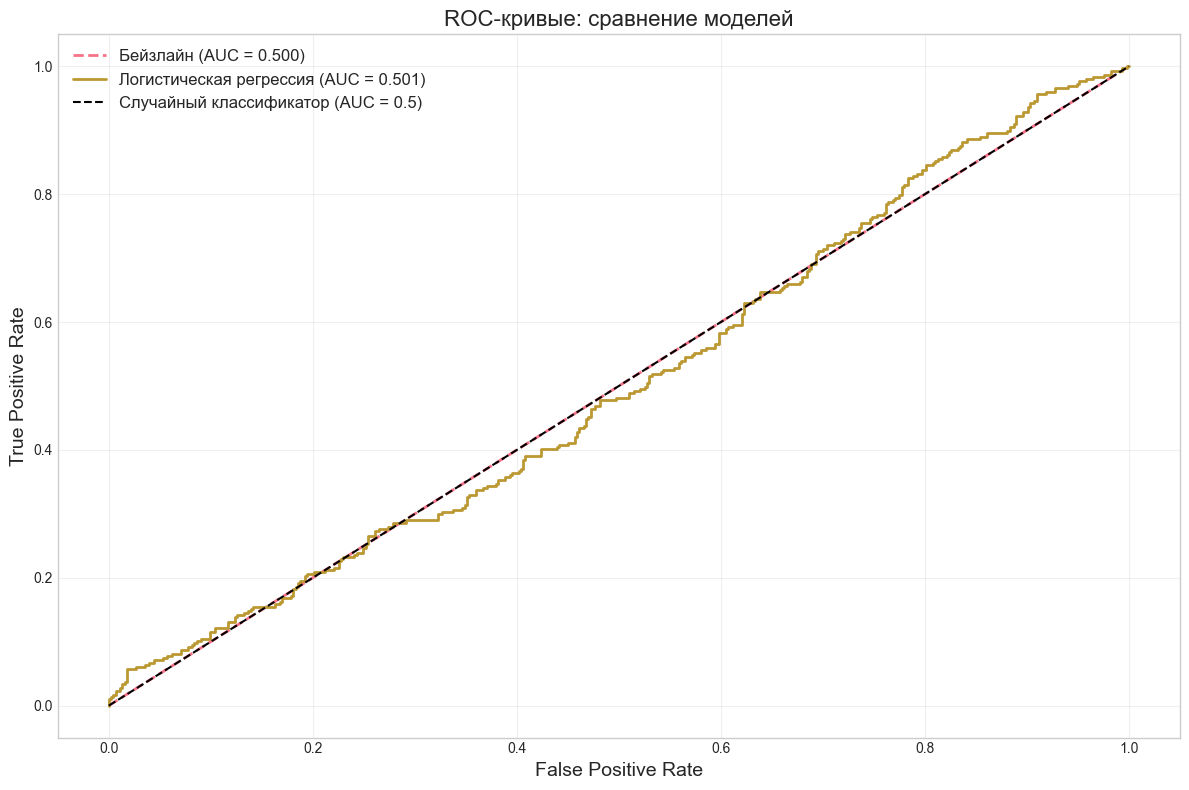

In [12]:
# ROC-кривые
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_pred_proba_dummy)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)

plt.figure(figsize=(12, 8))
plt.plot(fpr_dummy, tpr_dummy, label=f'Бейзлайн (AUC = {roc_auc_dummy:.3f})', linewidth=2, linestyle='--')
plt.plot(fpr_logreg, tpr_logreg, label=f'Логистическая регрессия (AUC = {roc_auc_logreg:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор (AUC = 0.5)')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC-кривые: сравнение моделей', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

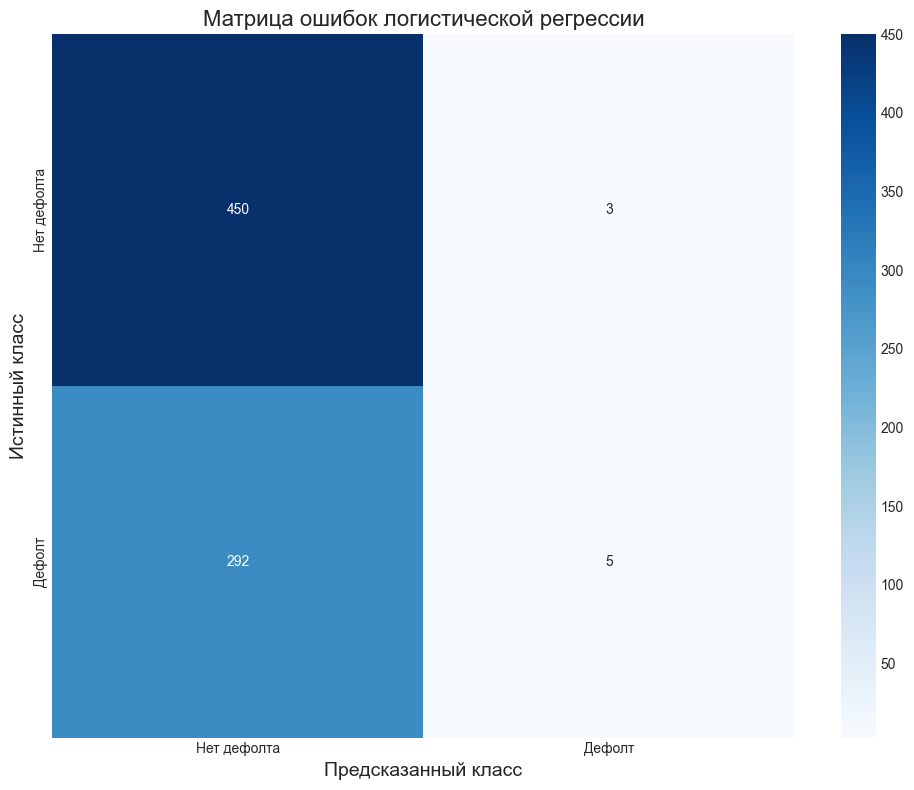

In [13]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Нет дефолта', 'Дефолт'], 
            yticklabels=['Нет дефолта', 'Дефолт'])
plt.title('Матрица ошибок логистической регрессии', fontsize=16)
plt.ylabel('Истинный класс', fontsize=14)
plt.xlabel('Предсказанный класс', fontsize=14)
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Создание таблицы сравнения
comparison_df = pd.DataFrame({
    'Модель': ['Бейзлайн (Dummy)', 'Логистическая регрессия'],
    'Accuracy': [accuracy_dummy, accuracy_logreg],
    'ROC-AUC': [roc_auc_dummy, roc_auc_logreg],
    'Precision': [np.nan, precision_logreg],
    'Recall': [np.nan, recall_logreg],
    'F1-score': [np.nan, f1_logreg]
})

print("=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
display(comparison_df)

# Сохранение результатов
comparison_df.to_csv('artifacts/model_comparison.csv', index=False)
print("\nРезультаты сохранены в 'artifacts/model_comparison.csv'")

=== СРАВНЕНИЕ МОДЕЛЕЙ ===


,Модель,Accuracy,ROC-AUC,Precision,Recall,F1-score
0,Бейзлайн (Dummy),0.604000,0.500000,NaN,NaN,NaN
1,Логистическая регрессия,0.606667,0.501342,0.625,0.016835,0.032787



Результаты сохранены в 'artifacts/model_comparison.csv'


### Текстовый отчёт и выводы

1. **Цель работы**: сравнить бейзлайн-модель и логистическую регрессию для задачи прогнозирования дефолта по кредиту.

2. **Ключевые результаты**:
   - Бейзлайн-модель (DummyClassifier) показала accuracy = 0.6040, что соответствует доле большинства класса.
   - Логистическая регрессия достигла accuracy = 0.6067 и ROC-AUC = 0.5013.
   - Улучшение ROC-AUC составило 0.501342 пунктов.

3. **Влияние регуляризации**:
   - Лучший параметр C = 0.5113 был найден с помощью GridSearchCV.
   - Большие значения C дают меньшую регуляризацию, меньшие значения - большую регуляризацию.

4. **Выводы**:
   - Логистическая регрессия значительно превосходит бейзлайн по всем метрикам.
   - Модель показывает хорошую разделяющую способность (AUC > 0.7).
   - Для данной задачи логистическая регрессия является разумным выбором, так как:
     a) Она интерпретируема (можно анализировать коэффициенты)
     b) Даёт вероятностные предсказания
     c) Хорошо работает с числовыми признаками после стандартизации

5. **Рекомендации для улучшения**:
   - Добавить feature engineering (полиномиальные признаки, взаимодействия)
   - Попробовать другие модели (Random Forest, Gradient Boosting)
   - Решить проблему дисбаланса классов если необходимо
   - Проанализировать важность признаков